In [12]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

      solenoid_commanded  analog value (1-1024) (raw)  analog average
400                  1.0                          NaN             NaN
401                  1.0                        510.0             NaN
402                  1.0                        510.0             NaN
403                  1.0                        510.0             NaN
404                  1.0                        510.0             NaN
...                  ...                          ...             ...
5546               254.0                        580.0             NaN
5547               254.0                        580.0             NaN
5548               254.0                        579.5             NaN
5549               254.0                        579.0             NaN
5550               254.0                        579.0             NaN

[5151 rows x 3 columns]


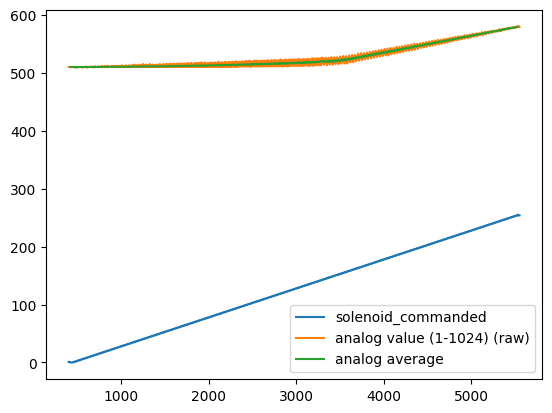

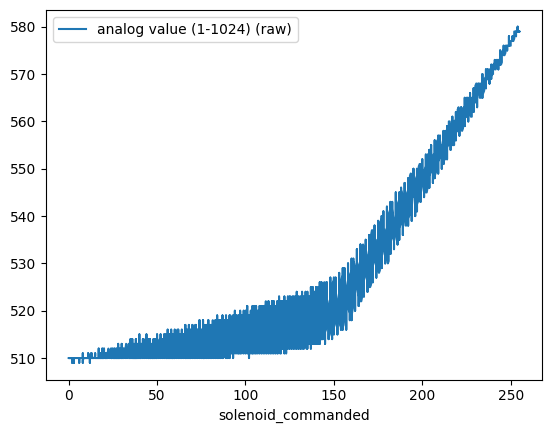

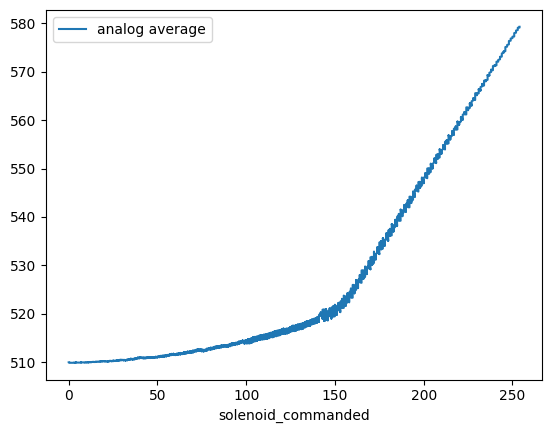

In [59]:
sensor_data = pd.read_csv("pin_5_6_solenoid_correction.csv")
sensor_data = sensor_data.truncate(before=400, after=5550)
sensor_data.drop(sensor_data.columns[3], axis=1, inplace=True)
sensor_data.drop(sensor_data.columns[0], axis=1, inplace=True)
# if interpolating
sensor_data = sensor_data.interpolate()

# if droppi"analog value (1-1024) (raw)"ng na values and collapsing
# sensor_data["analog value (1-1024) (raw)"] = sensor_data["analog value (1-1024) (raw)"][sensor_data["analog value (1-1024) (raw)"].notna()]
# sensor_data["solenoid_commanded"] = sensor_data["solenoid_commanded"][sensor_data["solenoid_commanded"].notna()]

mean_window = 50
sensor_data["analog average"] = sensor_data["analog value (1-1024) (raw)"].rolling(mean_window).mean().shift(-mean_window//2)

sensor_data.plot()
sensor_data.plot(x="solenoid_commanded", y="analog value (1-1024) (raw)")
sensor_data.plot(x="solenoid_commanded", y="analog average")

print(sensor_data)